# Formation Energy Prediction using *Deml 2016* Descriptors

This notebook uses the method from [Deml 2016](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.085142) to predict formation energy of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
training_files = ["datasets/deml_dataset.csv"]
delimiters = [',']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~2000 compounds with data extracted from the Open Quantum Materials Database (OQMD)

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
    
    training_set = pd.DataFrame()
    
    for i in range(len(files)):
        training_set = pd.read_csv(files[i], sep=sep[i])
        
    return training_set

training_set = load_training_set(training_files, delimiters)

### Create PyMatGen composition objects

In [4]:
comp_objects = [Composition(comp) for comp in training_set["composition"]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,composition,delta_e,comp_obj
0,As1Y1,-1.555732,"(As, Y)"
1,Ga1P1,-0.534169,"(Ga, P)"
2,Ga2Mg1S4,-1.068504,"(S, Mg, Ga)"
3,Cd4K1O12V3,-1.968765,"(O, Cd, K, V)"
4,Al1Ca1Fe1Na1O12Si4,-2.949067,"(O, Na, Al, Si, Ca, Fe)"
5,Hf1O3Pb1,-2.830320,"(Hf, O, Pb)"
6,Al2Ba2Co1F14Mn1,-3.488390,"(Ba, F, Co, Al, Mn)"
7,Ba2Cd1F14Fe2Mn1,-3.007836,"(Ba, F, Fe, Cd, Mn)"
8,Be2O4Si1,-3.020793,"(O, Be, Si)"
9,Ba2Ca1Cu1F14Ga2,-3.325601,"(Ba, F, Ca, Cu, Ga)"


## Compute descriptors using MatMiner
Here, we compute composition based attributes as described in *Deml 2016* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [5]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.Stoichiometry(p_list=None, num_atoms=True).featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElementProperty(method="deml").featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbital(orbitals=["s","p","d"], props=["avg","frac"]).featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.TMetalFraction().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ElectronAffinity().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ElectronegativityDiff().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.FERECorrection().featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

all_descriptors, attr_names = calc_attributes(training_set)

CPU times: user 7.55 s, sys: 100 ms, total: 7.65 s
Wall time: 7.98 s


## Predicting formation energy

In [6]:
training_set_use = all_descriptors.replace("None", np.nan)
training_set_use = all_descriptors.replace(np.inf, np.nan)
training_set_use = training_set_use.dropna()

training_set_use

,composition,delta_e,comp_obj,Number of atoms,maximum GGAU_Etot,maximum atom_mass,maximum atom_num,maximum atom_radius,maximum boiling_point,maximum col_num,...,maximum EN difference,mean EN difference,minimum EN difference,range EN difference,std_dev EN difference,maximum FERE Correction,mean FERE Correction,minimum FERE Correction,range FERE Correction,std_dev FERE Correction
0,As1Y1,-1.555732,"(As, Y)",2.0,-4.65,88.905850,39.0,180.0,3609.0,15.0,...,0.96,0.960000,0.96,0.00,0.000000,0.667379,0.128689,-0.410000,1.077379,0.538689
1,Ga1P1,-0.534169,"(Ga, P)",2.0,-3.03,69.723000,31.0,130.0,2477.0,15.0,...,0.38,0.380000,0.38,0.00,0.000000,0.660000,-0.010000,-0.680000,1.340000,0.670000
2,Ga2Mg1S4,-1.068504,"(S, Mg, Ga)",7.0,-1.54,69.723000,31.0,150.0,2477.0,16.0,...,1.27,0.936667,0.77,0.50,0.250000,0.660000,0.301429,0.060000,0.600000,0.280837
3,Cd4K1O12V3,-1.968765,"(O, Cd, K, V)",20.0,-0.91,112.411000,48.0,220.0,3680.0,16.0,...,2.62,1.881250,1.75,0.87,0.396737,0.350000,0.153955,-0.451973,0.801973,0.258769
4,Al1Ca1Fe1Na1O12Si4,-2.949067,"(O, Na, Al, Si, Ca, Fe)",20.0,-1.23,55.845000,26.0,180.0,3173.0,16.0,...,2.51,1.818750,1.54,0.97,0.411174,0.720000,0.274637,-0.152134,0.872134,0.159620
6,Al2Ba2Co1F14Mn1,-3.488390,"(Ba, F, Co, Al, Mn)",20.0,-1.86,137.327000,56.0,215.0,3200.0,17.0,...,3.09,2.575000,2.10,0.99,0.363963,0.720000,0.228353,-0.104349,0.824349,0.214552
7,Ba2Cd1F14Fe2Mn1,-3.007836,"(Ba, F, Fe, Cd, Mn)",20.0,-0.91,137.327000,56.0,215.0,3134.0,17.0,...,3.09,2.533333,2.15,0.94,0.360278,0.535501,0.163857,-0.152134,0.687635,0.165480
8,Be2O4Si1,-3.020793,"(O, Be, Si)",7.0,-3.75,28.085500,14.0,110.0,3173.0,16.0,...,1.87,1.760000,1.54,0.33,0.165000,0.427225,0.293258,0.230000,0.197225,0.076571
9,Ba2Ca1Cu1F14Ga2,-3.325601,"(Ba, F, Ca, Cu, Ga)",20.0,-1.86,137.327000,56.0,215.0,3200.0,17.0,...,3.09,2.596667,2.08,1.01,0.457766,0.660000,0.246270,0.057419,0.602581,0.181765
10,Ge1O4Zn2,-1.809053,"(Ge, O, Zn)",7.0,-1.27,72.640000,32.0,135.0,3093.0,16.0,...,1.79,1.670000,1.43,0.36,0.180000,0.430000,0.276080,0.152561,0.277439,0.100806


In [7]:
#Band gap data
delta_e = np.array(training_set_use["delta_e"], dtype=float)
print delta_e

#Energy range data
delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

[-1.55573181 -0.53416896 -1.06850412 ...,  0.46489684 -4.07700786 -2.733333  ]
['n' 'n' 'n' ..., 'p' 'n' 'n']


### Predict formation energy range using classifiers

In [8]:
#Classifier step
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [9]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,2027,0
p,2,11


In [10]:
#Classifier step
model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], energy_range)
prediction = model2.predict(training_set_use[attr_names])

In [11]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,2027,0
p,0,13


In [12]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
prediction = rf_model.predict(training_set_use[attr_names])

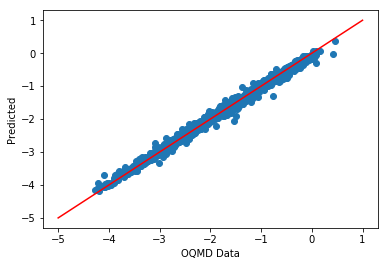

In [14]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,2), range(-5,2), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [15]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.116914797865
CPU times: user 8.49 s, sys: 96.5 ms, total: 8.59 s
Wall time: 9.16 s


### Decision Tree Regressor

In [16]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [17]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

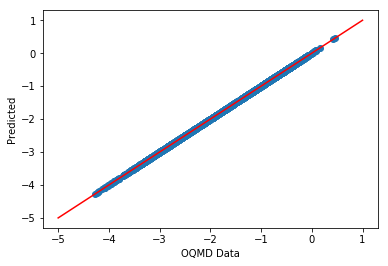

In [18]:
plt.scatter(delta_e, dt_prediction)
plt.plot(range(-5,2), range(-5,2), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [19]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.161658436413
CPU times: user 1.1 s, sys: 8.08 ms, total: 1.11 s
Wall time: 1.12 s
